###Example workflow for SFRmaker post-processing module
Requires Mat1 and Mat2 tables, as produced by the methods in **sfr_classes.py** (e.g. via the example **main** scripts)  
Also requires **flopy**, for reading the MODFLOW DIS file (https://github.com/modflowpy/flopy)

In [1]:
import sys
#sys.path.append('../Documents/GitHub/SFR')
sys.path.append('D:\ATLData\Documents\GitHub\SFR')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from postproc import *
import sfr_plots

%matplotlib inline

####Instantiate SFR object

In [2]:
sfr = SFRdata(Mat1='SFRoutput/Mat1.csv',Mat2='SFRoutput/Mat2_elevs_edited.csv',
             mfpath='GWV', mfnam='LPR_PP2_1_12_15.nam', mfdis='LPR_PP2_1_12_15_adjusted_to_streambed.dis',
             xll=1795400, yll=1424400)

GWV\LPR_PP2_1_12_15_adjusted_to_streambed.dis
Parsing the namefile --> GWV\LPR_PP2_1_12_15.nam
Setting filehandles:


####Get initial streambed top elevations from DEM  
* elevations are computed using the rasterstats package (<https://github.com/perrygeo/python-raster-stats>)
* minimum elevations from the dem are taken as the default

In [3]:
sfr.reset_m1_streambed_top_from_dem(dem='input/dem10mwtm_ft')

computing cell geometries...
computing zonal statistics...
Updating min/max elevations in Mat2 from elevations in Mat1...
DEM min elevations assigned to top_streambed column in m1


####Incorporate field measurements of ditch elevation by replacing elevation values obtained from the DEM  
* for each field measurement, the closest SFR cell within a distance of 200 m was established
* the streambed top / land surface elevation at this SFR cell was replaced with the field value

In [ ]:
sfr.incorporate_field_elevations(shpfile='shps/MNF_PKJ_ditch_elevs.shp', elevs_field='elev_ft', distance_tol=200)

####The map_confluences method compiles a dataframe of all SFR confluences, with node, streambed elevations, and segments 
* Elevation values in Mat2 are updated to be consistent with the *lowest* value at each confluence

In [6]:
sfr.map_confluences()

Mapping 16 confluences and updating segment min/max elevations in Mat2...
Done, see confluences attribute.


In [7]:
sfr.confluences

,segment,upsegs,node,elev
8,8,"[7, 11]",926933,1065.813721
9,9,"[6, 15]",900265,1063.773560
10,10,[9],902397,1063.773560
11,11,"[10, 17]",926985,1063.773560
13,13,"[8, 16]",934217,1060.006348
20,20,[36],891221,974.572754
21,21,"[1, 40]",607132,1089.270000
22,22,"[2, 30]",600723,1092.359741
23,23,"[18, 38]",743333,1086.847656
24,24,[23],757449,1028.642090


####Manually adjust some of the ditch starting (reach 1) elevations 
* to be consistent with the ditch being at least several feet below the land surface (from DEM)
* and so that the ditch headwaters are only slightly above downstream elevation measurements

In [8]:
sfr.m2.loc[1, 'Max'] = 1090.1
sfr.m2.loc[2, 'Max'] = 1093
sfr.m2.loc[3, 'Max'] = 1092
sfr.m2.loc[4, 'Max'] = 1089
sfr.m2.loc[5, 'Max'] = 1089
sfr.m2.loc[30, 'Max'] = 1099
sfr.m2.loc[37, 'Max'] = 1091
sfr.m2.loc[41, 'Min'] = 1085
sfr.m2.loc[16, 'Min'] = sfr.m2.ix[16, 'Min'] -2
sfr.m2.loc[16, 'Max'] = sfr.m2.ix[16, 'Max'] -2
sfr.m2.loc[7, 'Max'] = sfr.m2.ix[7, 'Max'] -2
sfr.m1.loc[sfr.m1.segment == 7, 'top_streambed'] = sfr.m1.loc[sfr.m1.segment == 7, 'top_streambed'] -2
sfr.m1.loc[sfr.m1.segment == 7, 'landsurface'] = sfr.m1.loc[sfr.m1.segment == 7, 'landsurface'] -2

sfr.m1.loc[sfr.m1.segment == 16, 'top_streambed'] = sfr.m1.ix[sfr.m1.segment == 16, 'top_streambed'].values -2
sfr.m1.loc[sfr.m1.segment == 16, 'landsurface'] = sfr.m1.ix[sfr.m1.segment == 16, 'landsurface'].values -2

In [9]:
sfr.map_confluences()

Mapping 16 confluences and updating segment min/max elevations in Mat2...
Done, see confluences attribute.


In [10]:
sfr.confluences

,segment,upsegs,node,elev
8,8,"[7, 11]",926933,1063.773560
9,9,"[6, 15]",900265,1063.773560
10,10,[9],902397,1063.773560
11,11,"[10, 17]",926985,1063.773560
13,13,"[8, 16]",934217,1058.006348
20,20,[36],891221,974.572754
21,21,"[1, 40]",607132,1089.270000
22,22,"[2, 30]",600723,1092.359741
23,23,"[18, 38]",743333,1086.847656
24,24,[23],757449,1028.642090


In [11]:
sfr.m2[['Min', 'Max']]

,Min,Max
1,1089.270000,1090.100000
2,1092.359741,1093.000000
3,1089.660000,1092.000000
4,1086.590000,1089.000000
5,1085.000000,1089.000000
6,1063.773560,1088.265991
7,1063.773560,1068.215332
8,1058.006348,1063.773560
9,1063.773560,1063.773560
10,1063.773560,1063.773560


####Smooth reach elevations in segment interiors
* using field measurements and minimum elevation values from DEM

In [12]:
sfr.smooth_interior_elevations()


Smoothing segment interiors...

starting from elevations in m1.landsurface
calculating slopes...
Done, see smooth_segment_interiors.txt for report.


####The outsegs table allows complete stream profiles to be produced from headwaters to outlet
(see complete_profiles.pdf)  
* include profiles of the minimum elevations sampled from the DEM, which were saved to the "landsurface" column in Mat1 (sfr.m1 attribute)

In [16]:
sfr.plot_stream_profiles(add_profiles={'Minimum DEM elevation': 'landsurface'})

listing unique segment sequences...


####Use the outseg information to check the routing  
* sfr segments are colored by outlet

Done


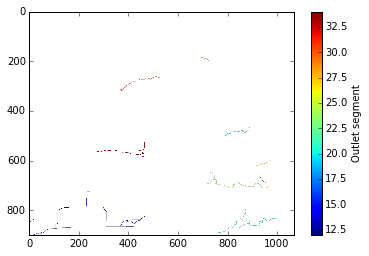

In [17]:
sfr.plot_routing(outpdf='LPR_routing.pdf')

####Estimate stream widths 
using the cumulative lengths in each cell, and starting arbolate sum values specified in Mat2, in the column 'in_arbolate' (in km, which the unit used in NHD)

In [18]:
sfr.estimate_stream_widths()

estimating stream widths...
Done


####Consolidate SFR conductances for model cells with multiple SFR reaches
total conductance for collocated reaches; put all conductance in widest reach (largest arbolate sum),  
set conductance in other reaches close to 0 via. streambed K

In [19]:
sfr.consolidate_conductance()

Assigning total SFR conductance to dominant reach in cells with multiple reaches...


###Reset the model top elevations so that they coincide with the SFR streambed top at the locations of SFR cells  
* enforce that streambed thickness be less than minimum thickness for layer 1 (to avoid MODFLOW altitude errors)
* update the dis file for the sfr object  


In [23]:
sfr.reset_model_top_2streambed(outdisfile='LPR_04_27_2015_adjusted_to_streambed.dis')


 not valid, workspace-folder was changed to D:\ATLData\LittlePlover\2_from_ALEAF_SFR



###Run suite of diagnostics to check for common SFR problems  
* the method below calls the **diagnostics.py** module

In [26]:
sfr.run_diagnostics()

Checking for continuity in segment and reach numbering...
passed.

Checking for circular routing...
passed.

Checking for model cells with multiple non-zero SFR conductances...
passed.

Checking Mat1 for downstream rises in streambed elevation...
passed.

Checking Mat1 for segments with reach 1 higher than last reach ...
passed.

Checking for MODFLOW altitude errors...
passed.
Need a shapefile of the model domain edge to check for interior outlets.


####Write a shapefile for visualizing the SFR network####  

In [28]:
sfr.write_shapefile(xll=1795400, yll=1424400, outshp='SFRoutput/LPR_SFR_20150427.shp', prj='WTMft.prj')

writing SFRoutput/LPR_SFR_20150427.shp...


####Finally make an SFR package file, which can be used as-is, or imported into Groundwater Vistas:####

In [29]:
sfr.write_tables(basename='LPR_SFR_20150427')

Mat1 and 2 saved to LPR_SFR_20150427mat1.csv and LPR_SFR_20150427mat2.csv


In [30]:
sfr.write_sfr_package(basename='LPR_SFR_20150427')

writing LPR_SFR_20150427.sfr
Done
